In [1]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib qt

nx = 9
ny = 6

In [2]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners 
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(100)


ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# print("mtx: " ,mtx)
# print("dist: " ,dist)

# Read in an image
img = cv2.imread('camera_cal/calibration1.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)

# cv2.imshow('img',undistorted)
# cv2.waitKey(1000)
# print("undistorted")
# cv2.destroyAllWindows()


In [16]:
def corners_unwarp(undistorted_img, mtx, dist):
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    #dst = np.float32([[0,0],[undistorted_img.shape[1]-100,100],[undistorted_img.shape[1]-100,undistorted_img.shape[0]-100],[100,undistorted_img.shape[0]-100]])

    print("img.shape[0]", undistorted_img.shape[0])
    print("img.shape[1]", undistorted_img.shape[1])
#    src  =  np.float32([[undistorted_img.shape[1]//2 - 20, undistorted_img.shape[0]//2], [undistorted_img.shape[1]//2+20, undistorted_img.shape[0]//2], [undistorted_img.shape[1], undistorted_img.shape[0]], [0, undistorted_img.shape[0]]])
#    src  =  np.float32([[600, undistorted_img.shape[0]//2 + 65], [undistorted_img.shape[1]-600, undistorted_img.shape[0]//2+65], [undistorted_img.shape[1], undistorted_img.shape[0]], [0, undistorted_img.shape[0]]])
    src  =  np.float32([[525, undistorted_img.shape[0]//2 + 90],                         [undistorted_img.shape[1] - 525, undistorted_img.shape[0]//2 + 90],                                 [undistorted_img.shape[1], undistorted_img.shape[0]], [0, undistorted_img.shape[0]]])
    dst  =  np.float32([[0, 0],                                                          [undistorted_img.shape[1], 0],                                 [undistorted_img.shape[1]-280, undistorted_img.shape[0]], [280, undistorted_img.shape[0]]])
#    dst  =  np.float32([[undistorted_img.shape[1]//2 -20, undistorted_img.shape[0]//2], [undistorted_img.shape[1]//2+20, undistorted_img.shape[0]//2], [undistorted_img.shape[1], undistorted_img.shape[0]], [0, undistorted_img.shape[0]]])    

    
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    print("M: ", M)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undistorted_img, M, (undistorted_img.shape[1], undistorted_img.shape[0]), flags=cv2.INTER_LINEAR)
    
    return warped, M

def hist(img):
    bottom_half = np.sum(img[img.shape[0]//2:,:], axis=0)
    #histogram = sum(bottom_half/255)
    return bottom_half


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    print("nonzero: ", nonzero)
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    print("nonzerox: ", nonzerox )
    print("nonzeroy: ", nonzeroy )

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    print(binary_warped.shape)

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low =   leftx_current - margin  # Update this
        win_xleft_high =  leftx_current + margin  # Update this
        
        win_xright_low =  rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin# Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds =  ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    print("leftx: ", leftx)
    print("lefty: ", lefty)
    
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img



In [17]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    image_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    channel_s = image_hls[:,:,2]
    # 3) Return a binary image of threshold result
    binary = np.zeros_like(channel_s)
    binary[(channel_s > thresh[0]) & (channel_s <= thresh[1])] = 1
    binary_output = binary # placeholder line
    return binary_output
    


img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
nonzero:  (array([  0,   0,   0, ..., 716, 716, 716], dtype=int64), array([  1,   2,   3, ..., 404, 405, 406], dtype=int64))
nonzerox:  [  1   2   3 ... 404 405 406]
nonzeroy:  [  0   0   0 ... 716 716 716]
(720, 1280)
leftx:  [384 385 386 ... 412 413 414]
lefty:  [640 640 640 ...  79  79  79]


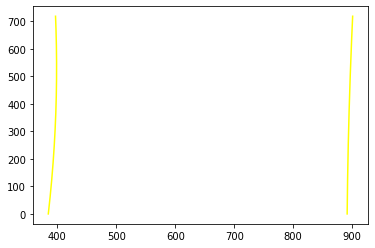

In [18]:
img = cv2.imread('test_images/straight_lines1.jpg')
undistorted_img = cal_undistort(img, objpoints, imgpoints)
cv2.imshow('img_orig',undistorted_img)
cv2.waitKey(1000)

#rgb = img[...,::-1].copy()
hls_binary = hls_select(undistorted_img, thresh=(70, 255))
hls_binary = hls_binary*255
cv2.imshow('img_binary', hls_binary)
cv2.waitKey(1000)

top_down, perspective_M = corners_unwarp(hls_binary, mtx, dist)
cv2.imshow('img_unwarped',top_down)
cv2.waitKey(1000)

out_img = fit_polynomial(top_down)
cv2.imshow("window", out_img)


